In [1]:
import json
import numpy as np
import pandas as pd
# from src import *

In [2]:
# Set path to data
path = '../data/raw/CDSA_.xlsx'

# Import data
cdsa = pd.read_excel(path, sheet_name='CDSA')
labs = pd.read_excel(path, sheet_name='repeat2')
cnss = pd.read_excel(path, sheet_name='repeat1_001')
cvss = pd.read_excel(path, sheet_name='repeat1_002')
urss = pd.read_excel(path, sheet_name='repeat1_003')
lrss = pd.read_excel(path, sheet_name='repeat1_004')
gits = pd.read_excel(path, sheet_name='repeat1_005')
guss = pd.read_excel(path, sheet_name='repeat1_006')
msss = pd.read_excel(path, sheet_name='repeat1_007')
skns = pd.read_excel(path, sheet_name='repeat1_008')
spss = pd.read_excel(path, sheet_name='repeat1_009')
oths = pd.read_excel(path, sheet_name='repeat1_010')

# Import columns from json file
with open('../data/dictionaries/columns.json') as f:
    columns, multiple_entry_cols, diagnosis = json.load(f).values()

In [3]:
for k, v in columns.items():
    if k in multiple_entry_cols:
        multiple_entry_cols[v] = multiple_entry_cols.pop(k)

In [4]:
def select_columns(df: pd.DataFrame,
                          columns: dict,
                          rename: bool = True) -> pd.DataFrame:
    """
    Filter columns of a dataframe based on the keys of a dictionary.
    """
    df_ = df[df.columns.intersection(columns.keys())]
    if rename:
        df_ = df_.rename(columns=columns)
    return df_

cdsa_ = select_columns(cdsa, columns)
labs_ = select_columns(labs, columns)
cnss_ = select_columns(cnss, columns)
cvss_ = select_columns(cvss, columns)
urss_ = select_columns(urss, columns)
lrss_ = select_columns(lrss, columns)
gits_ = select_columns(gits, columns)
guss_ = select_columns(guss, columns)
msss_ = select_columns(msss, columns)
skns_ = select_columns(skns, columns)
spss_ = select_columns(spss, columns)
oths_ = select_columns(oths, columns)

In [5]:
# Merge dataframes
ss = pd.merge(cnss_, cvss_, on=cnss_.columns.intersection(cvss_.columns).tolist(), how='outer')
ss = pd.merge(ss, urss_, on=ss.columns.intersection(urss_.columns).tolist(), how='outer')
ss = pd.merge(ss, lrss_, on=ss.columns.intersection(lrss_.columns).tolist(), how='outer')
ss = pd.merge(ss, gits_, on=ss.columns.intersection(gits_.columns).tolist(), how='outer')
ss = pd.merge(ss, guss_, on=ss.columns.intersection(guss_.columns).tolist(), how='outer')
ss = pd.merge(ss, msss_, on=ss.columns.intersection(msss_.columns).tolist(), how='outer')
ss = pd.merge(ss, skns_, on=ss.columns.intersection(skns_.columns).tolist(), how='outer')
ss = pd.merge(ss, spss_, on=ss.columns.intersection(spss_.columns).tolist(), how='outer')
ss = pd.merge(ss, oths_, on=ss.columns.intersection(oths_.columns).tolist(), how='outer')
ss = pd.merge(ss, labs_, on=ss.columns.intersection(labs_.columns).tolist(), how='outer')
df = pd.merge(cdsa_, ss, on=cdsa_.columns.intersection(ss.columns).tolist(), how='outer')

df.drop_duplicates(ignore_index=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             3199 non-null   object 
 1   patient_id         3769 non-null   object 
 2   age                3766 non-null   float64
 3   sex                3751 non-null   object 
 4   temperature        2961 non-null   float64
 5   triage_            302 non-null    object 
 6   blood_pressure     1026 non-null   object 
 7   weight             2958 non-null   float64
 8   failure_to_thrive  1247 non-null   object 
 9   height             2585 non-null   float64
 10  stunting           1066 non-null   object 
 11  spo2               1973 non-null   float64
 12  chills             2771 non-null   object 
 13  muac               972 non-null    object 
 14  gen_signs          557 non-null    object 
 15  lab_investigation  3759 non-null   object 
 16  diagnosis          703

In [6]:
def split_cells(df: pd.DataFrame,
                column: str,
                uv: list = None,
                sep: str = "&") -> pd.DataFrame:
    """
    Split the cells of a column into multiple rows
    """
    if uv is None:
        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)
    else:
        if not isinstance(uv, list):
            uv = list(uv)
        for i in uv:
            df[column] = df[column].str.replace(i, sep + i + sep)
        df[column] = df[column].str.replace(sep + r"\s+", sep, regex=True)
        df[column] = df[column].str.replace(sep + r"$", "", regex=True)
        df[column] = df[column].str.replace(r"^" + sep, "", regex=True)
        df[column] = df[column].str.replace(sep + sep, sep)

        df.rename(columns={column: "col"}, inplace=True)
        df = df.assign(col=df["col"].str.split(sep)).explode("col").reset_index(drop=True)
        df.rename(columns={"col": column}, inplace=True)

        df[column] = df[column].str.strip()

    return df

# Split cells
for k, v in multiple_entry_cols.items():
    df = split_cells(df, k, v)
    
# Drop duplicates in every column except duration
df.drop_duplicates(subset=df.columns.difference(["duration"]), inplace=True)

# Repopulate the cdsa columns
for col in df.columns.intersection(cdsa_.columns):
    df[col] = df.groupby("_uuid")[col].transform("first")

In [7]:
# Construct triage_signs
df["fever"] = np.where(df["temperature"] > 37.5, "Fever", np.nan)
df["failure_to_thrive"] = np.where(df["failure_to_thrive"] == "Yes", "Failure to thrive", np.nan)
df["stunting"] = np.where(df["stunting"] == "Yes", "Stunting", np.nan)
df["chills"] = np.where(df["chills"] == "Yes", "Chills", np.nan)

triage_cols = ["triage_", "fever", "failure_to_thrive", "stunting", "chills"]

df = pd.melt(df, id_vars=[i for i in df.columns if i not in triage_cols],
             value_vars=triage_cols, var_name="trg", value_name="trg_signs").drop("trg", axis=1).drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27344 entries, 0 to 57904
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county             23809 non-null  object 
 1   patient_id         27312 non-null  object 
 2   age                27292 non-null  float64
 3   sex                27118 non-null  object 
 4   temperature        21985 non-null  float64
 5   blood_pressure     8339 non-null   object 
 6   weight             22205 non-null  float64
 7   height             19573 non-null  float64
 8   spo2               13892 non-null  float64
 9   muac               7325 non-null   object 
 10  gen_signs          5134 non-null   object 
 11  lab_investigation  27304 non-null  object 
 12  diagnosis          27166 non-null  object 
 13  _uuid              27344 non-null  object 
 14  cns_signs          7418 non-null   object 
 15  duration           16306 non-null  float64
 16  cvs_signs          180 non-

In [8]:
# Convert all the object values to lowercase and remove leading and trailing whitespaces
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.replace(r"\s+", " ", regex=True)
    df[col] = df[col].str.lower().str.strip()

In [9]:
df["diagnosis"] = df["diagnosis"].str.replace(r"\d+", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("/", " andor ")
df["diagnosis"] = df["diagnosis"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(" andor ", "/", regex=True)

# Correct misspelled words
df["diagnosis"] = df["diagnosis"].str.replace("diarrhea", "diarrhoea")
df["diagnosis"] = df["diagnosis"].str.replace("g e", "gastroenteritis")
df["diagnosis"] = df["diagnosis"].str.replace("tuber culosis", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("tb", "tuberculosis")
df["diagnosis"] = df["diagnosis"].str.replace("s malaria", "malaria")
df["diagnosis"] = df["diagnosis"].str.replace("pmeumonia", "pneumonia")
df["diagnosis"] = df["diagnosis"].str.replace("urti", "uti")
df["diagnosis"] = df["diagnosis"].str.replace("anaemiasickle cell", "sickle cell")
df["diagnosis"] = df["diagnosis"].str.replace("extra pulmonary", "extrapulmonary")
df["diagnosis"] = df["diagnosis"].str.replace("malnourished", "malnutrition")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\btyphoi\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace("complicated", "severe")
df["diagnosis"] = df["diagnosis"].str.replace(r"\bty\b", "typhoid", regex=True)
df["diagnosis"] = df["diagnosis"].str.replace(r"\bmenegititis\b", "meningitis", regex=True)

df["diagnosis"] = df["diagnosis"].str.replace(r"\s+", " ", regex=True)
df["diagnosis"] = df["diagnosis"].str.strip()

df["diagnosis"] = df["diagnosis"].str.replace("cough cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("cough and cold", "cough/cold")
df["diagnosis"] = df["diagnosis"].str.replace("pneuonitis", "pneumonitis")
df["diagnosis"] = df["diagnosis"].str.replace("no pneumonia", "")
df["diagnosis"] = df["diagnosis"].str.replace("no ova and cyst", "")

In [10]:
df = split_cells(df, "diagnosis", diagnosis)

# If a value is not in the diagnosis list, replace it with NaN
df["diagnosis"] = df["diagnosis"].where(df["diagnosis"].isin(diagnosis), np.nan)

In [11]:
symptoms = ['trg_signs', 'gen_signs', 'cns_signs', 'cvs_signs', 'urs_signs', 'lrs_signs', 'git_signs', 'gus_signs', 'mss_signs', 'skn_signs', 'sps_signs', 'oth_signs']

df = pd.melt(df, id_vars=[i for i in df.columns if i not in symptoms],
             value_vars=symptoms, var_name="system", value_name="symptoms").drop_duplicates()

df.replace({"nan": np.NaN, "None": np.NaN, None:np.NaN}, inplace=True)
df['system'] = df['system'].str.replace('_signs', '')
df['patient_id'] = df['patient_id'].str.replace(' ', '')
df['patient_id'] = np.where(df['patient_id'].str.replace('/', '').str.isnumeric(), df['patient_id'], np.NAN)
df['age'] = np.where(df['age'] < 100, df['age'], np.NAN)
df['height'] = np.where(df['height'] < 300, df['height'], np.NAN)
df['weight'] = np.where(df['weight'] > 0, df['weight'], np.NAN)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
df['bmi'] = np.where((df['bmi'] > 0) & (df['bmi'] < 100), df['bmi'], np.NAN)
df['temperature'] = np.where(df['temperature'] > 10, df['temperature'], np.NAN)
df['spo2'] = np.where(df['spo2'] < 100, df['spo2'], np.NAN)
df['bp_systolic'] = df['blood_pressure'].str.split('/').str[0]
df['bp_systolic'] = pd.to_numeric(df['bp_systolic'], errors='coerce')
df['bp_systolic'] = np.where((df['bp_systolic'] >= 70) & (df['bp_systolic'] <= 190), df['bp_systolic'], np.NAN)
df['bp_diastolic'] = df['blood_pressure'].str.split('/').str[1]
df['bp_diastolic'] = pd.to_numeric(df['bp_diastolic'], errors='coerce')
df['bp_diastolic'] = np.where((df['bp_diastolic'] >= 40) & (df['bp_diastolic'] <= 100), df['bp_diastolic'], np.NAN)
df['duration'] = np.where((df['duration'] > 0) & (df['duration'] < 367), df['duration'], np.NAN)
df = df.replace('undefined', np.NAN)
df = df.map(lambda x: x.lower().strip() if isinstance(x, str) else x)
df.loc[df.symptoms.isna(), "system"] = np.NaN
# df.loc[df.lab_test.isna(), "lab_investigation"] = "no"
df.loc[df.bp_diastolic.isna(), "bp_systolic"] = np.NaN
df.loc[df.bp_systolic.isna(), "bp_diastolic"] = np.NaN
df.drop_duplicates(inplace=True)

df = df[['_uuid', 'patient_id', 'county', 'age', 'sex', 'height', 'weight', 'bmi', 'temperature', 'bp_systolic', 'bp_diastolic', 'spo2', 'muac', 'symptoms', 'duration', 'system', 'lab_investigation', 'lab_test', 'diagnosis']]

df.to_csv('../data/interim/cdsa.csv', index=False)

display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Index: 28771 entries, 0 to 431717
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _uuid              28771 non-null  object 
 1   patient_id         27372 non-null  object 
 2   county             24143 non-null  object 
 3   age                28677 non-null  float64
 4   sex                28500 non-null  object 
 5   height             20929 non-null  float64
 6   weight             23762 non-null  float64
 7   bmi                20716 non-null  float64
 8   temperature        23415 non-null  float64
 9   bp_systolic        8494 non-null   float64
 10  bp_diastolic       8494 non-null   float64
 11  spo2               13500 non-null  float64
 12  muac               8405 non-null   object 
 13  symptoms           18806 non-null  object 
 14  duration           18048 non-null  float64
 15  system             18806 non-null  object 
 16  lab_investigation  28728 n

None

,_uuid,patient_id,county,age,sex,height,weight,bmi,temperature,bp_systolic,bp_diastolic,spo2,muac,symptoms,duration,system,lab_investigation,lab_test,diagnosis
0,2db2bd9b-7aea-4713-8b87-2aed40670629,564378/21,kisumu,26.0,male,168.0,66.0,23.384354,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,yes,haemogramm,NaN
1,2db2bd9b-7aea-4713-8b87-2aed40670629,564378/21,kisumu,26.0,male,168.0,66.0,23.384354,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,yes,x-ray,NaN
8,9f6310c4-aaf3-4752-874a-e09f1ac6f0cd,366903/2021,kilifi,81.0,female,NaN,NaN,NaN,36.7,103.0,68.0,98.0,NaN,NaN,1.0,NaN,yes,pcr,NaN
11,e07aea58-59c0-42b8-bd28-79858401435a,584733/21,kisumu,22.0,female,161.5,86.0,32.972615,35.9,NaN,NaN,NaN,NaN,NaN,1.0,NaN,yes,sat,NaN
15,0ae5856a-e684-4dcb-85b5-515c86f20fde,535169/20,kisumu,25.0,male,162.0,60.0,22.862369,36.4,125.0,78.0,NaN,NaN,NaN,2.0,NaN,yes,stool examination,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431550,f720395b-4e9a-4dbb-b51e-1c90907439b5,057510,kisumu,1.2,female,71.2,7.2,14.202752,NaN,NaN,NaN,NaN,green,getting ill often and taking a long time to re...,30.0,oth,no,NaN,malnutrition
431585,f8718d71-44c4-4dd9-8723-b3bd0700879a,069995,kisumu,5.0,male,98.0,14.0,14.577259,36.0,NaN,NaN,NaN,red,getting ill often and taking a long time to re...,60.0,oth,no,NaN,malnutrition
431689,fddcdce5-5b2d-4b3b-9e65-b106951a068e,086054/23,kisumu,5.0,male,105.2,9.5,8.584048,36.0,111.0,66.0,97.0,red,feeling cold most of the time,7.0,oth,no,NaN,malnutrition
431697,fe2d7989-3aaf-4c1f-8270-b1be85f67b4b,084624/23,kisumu,10.0,female,120.5,15.0,10.330401,36.0,NaN,NaN,NaN,red,feeling cold most of the time,7.0,oth,no,NaN,malnutrition


### Target variable: Diagnosis
The target variable is `diagnosis`. It is a categorical variable with 29 unique values. The top five diagnoses are malaria (795), pneumonia (789), covid (561), malnutrition (446), and diarrhoea (345). The top five diagnoses account for 86.05% of the data. Like we had imagined, class imbalance is a problem in this dataset. We will have to address this issue when we start building models.

,diagnosis,count
0,malaria,795
1,pneumonia,789
2,covid,561
3,malnutrition,446
4,diarrhoea,345
5,tuberculosis,260
6,gastroenteritis,158
7,cough/cold,16
8,uti,7
9,sickle cell,4


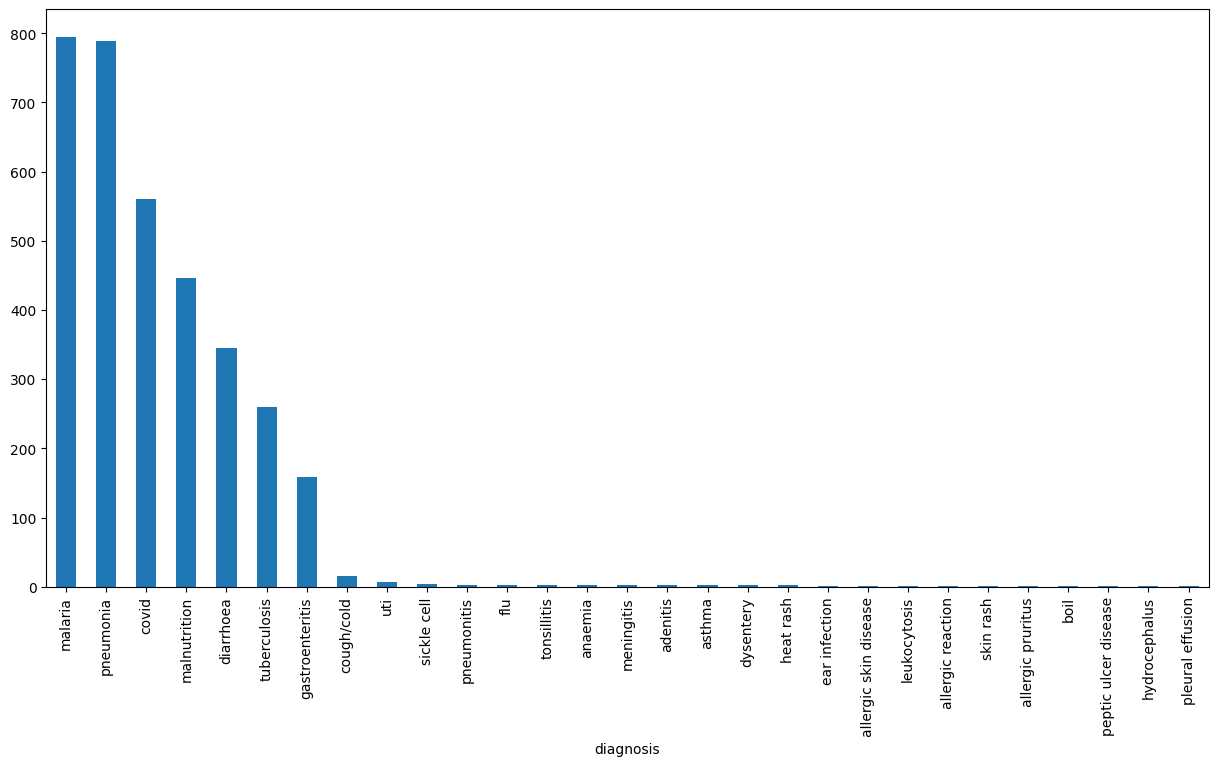

In [12]:
diagnosis_by_id = df[["_uuid", "diagnosis"]].drop_duplicates()
diagnosis_by_id.diagnosis.value_counts().plot(kind="bar", figsize=(15, 7.5))
diagnosis_by_id.diagnosis.value_counts().reset_index()

,sex,count
0,male,1880
1,female,1829


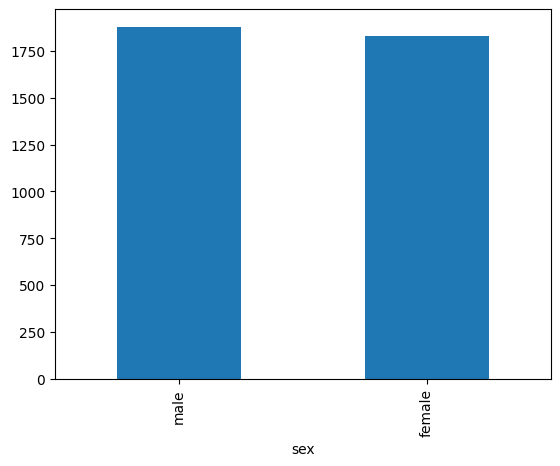

In [13]:
sex_by_id = df[["_uuid", "sex"]].drop_duplicates()
sex_by_id.sex.value_counts().plot(kind="bar")
sex_by_id.sex.value_counts().reset_index()

,muac,count
0,green,390
1,red,387
2,yellow,193


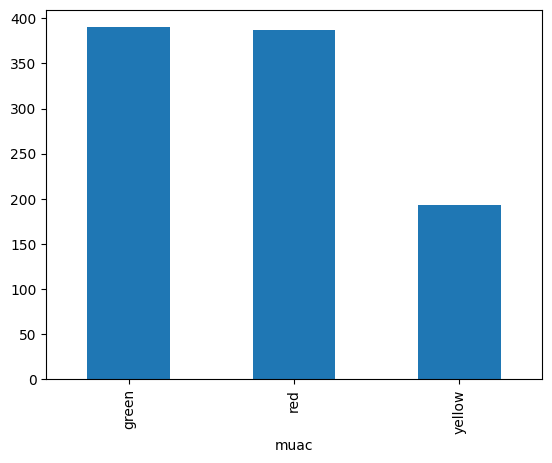

In [14]:
muac_by_id = df[["_uuid", "muac"]].drop_duplicates()
muac_by_id.muac.value_counts().plot(kind="bar")
muac_by_id.muac.value_counts().reset_index()

,lab_investigation,count
0,yes,2654
1,no,1070


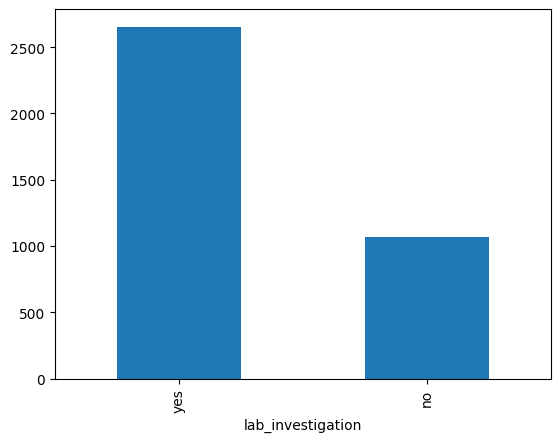

In [15]:
lab_investigation_by_id = df[["_uuid", "lab_investigation"]].drop_duplicates()
lab_investigation_by_id.lab_investigation.value_counts().plot(kind="bar")
lab_investigation_by_id.lab_investigation.value_counts().reset_index()

,lab_test,count
0,microscopy,818
1,x-ray,521
2,sat,410
3,covid-rdt,328
4,stool examination,314
5,pcr,209
6,genexpert,152
7,mrdt,122
8,haemogramm,99
9,culture,5


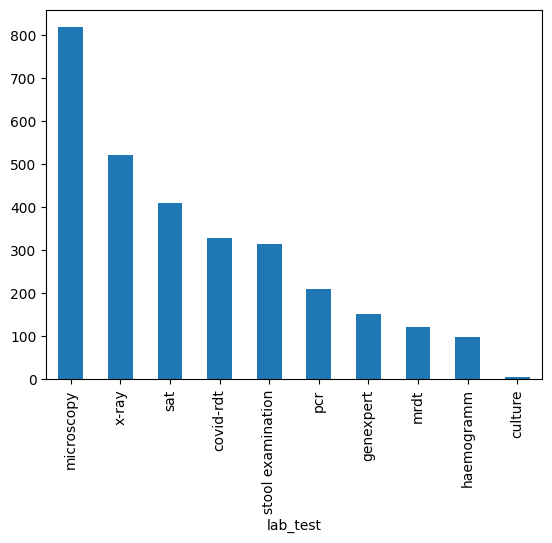

In [16]:
lab_test_by_id = df[["_uuid", "lab_test"]].drop_duplicates()
lab_test_by_id.lab_test.value_counts().plot(kind="bar")
lab_test_by_id.lab_test.value_counts().reset_index()

,symptoms,count
0,headache,924
1,loose and watery stools of diarrhoea,790
2,dry cough,765
3,fatigue,755
4,"difficulty breathing, especially at rest, or u...",690
5,chills,619
6,fever,558
7,"cough, which may produce greenish, yellow or e...",554
8,failure to thrive,412
9,muscle or joint pain,353


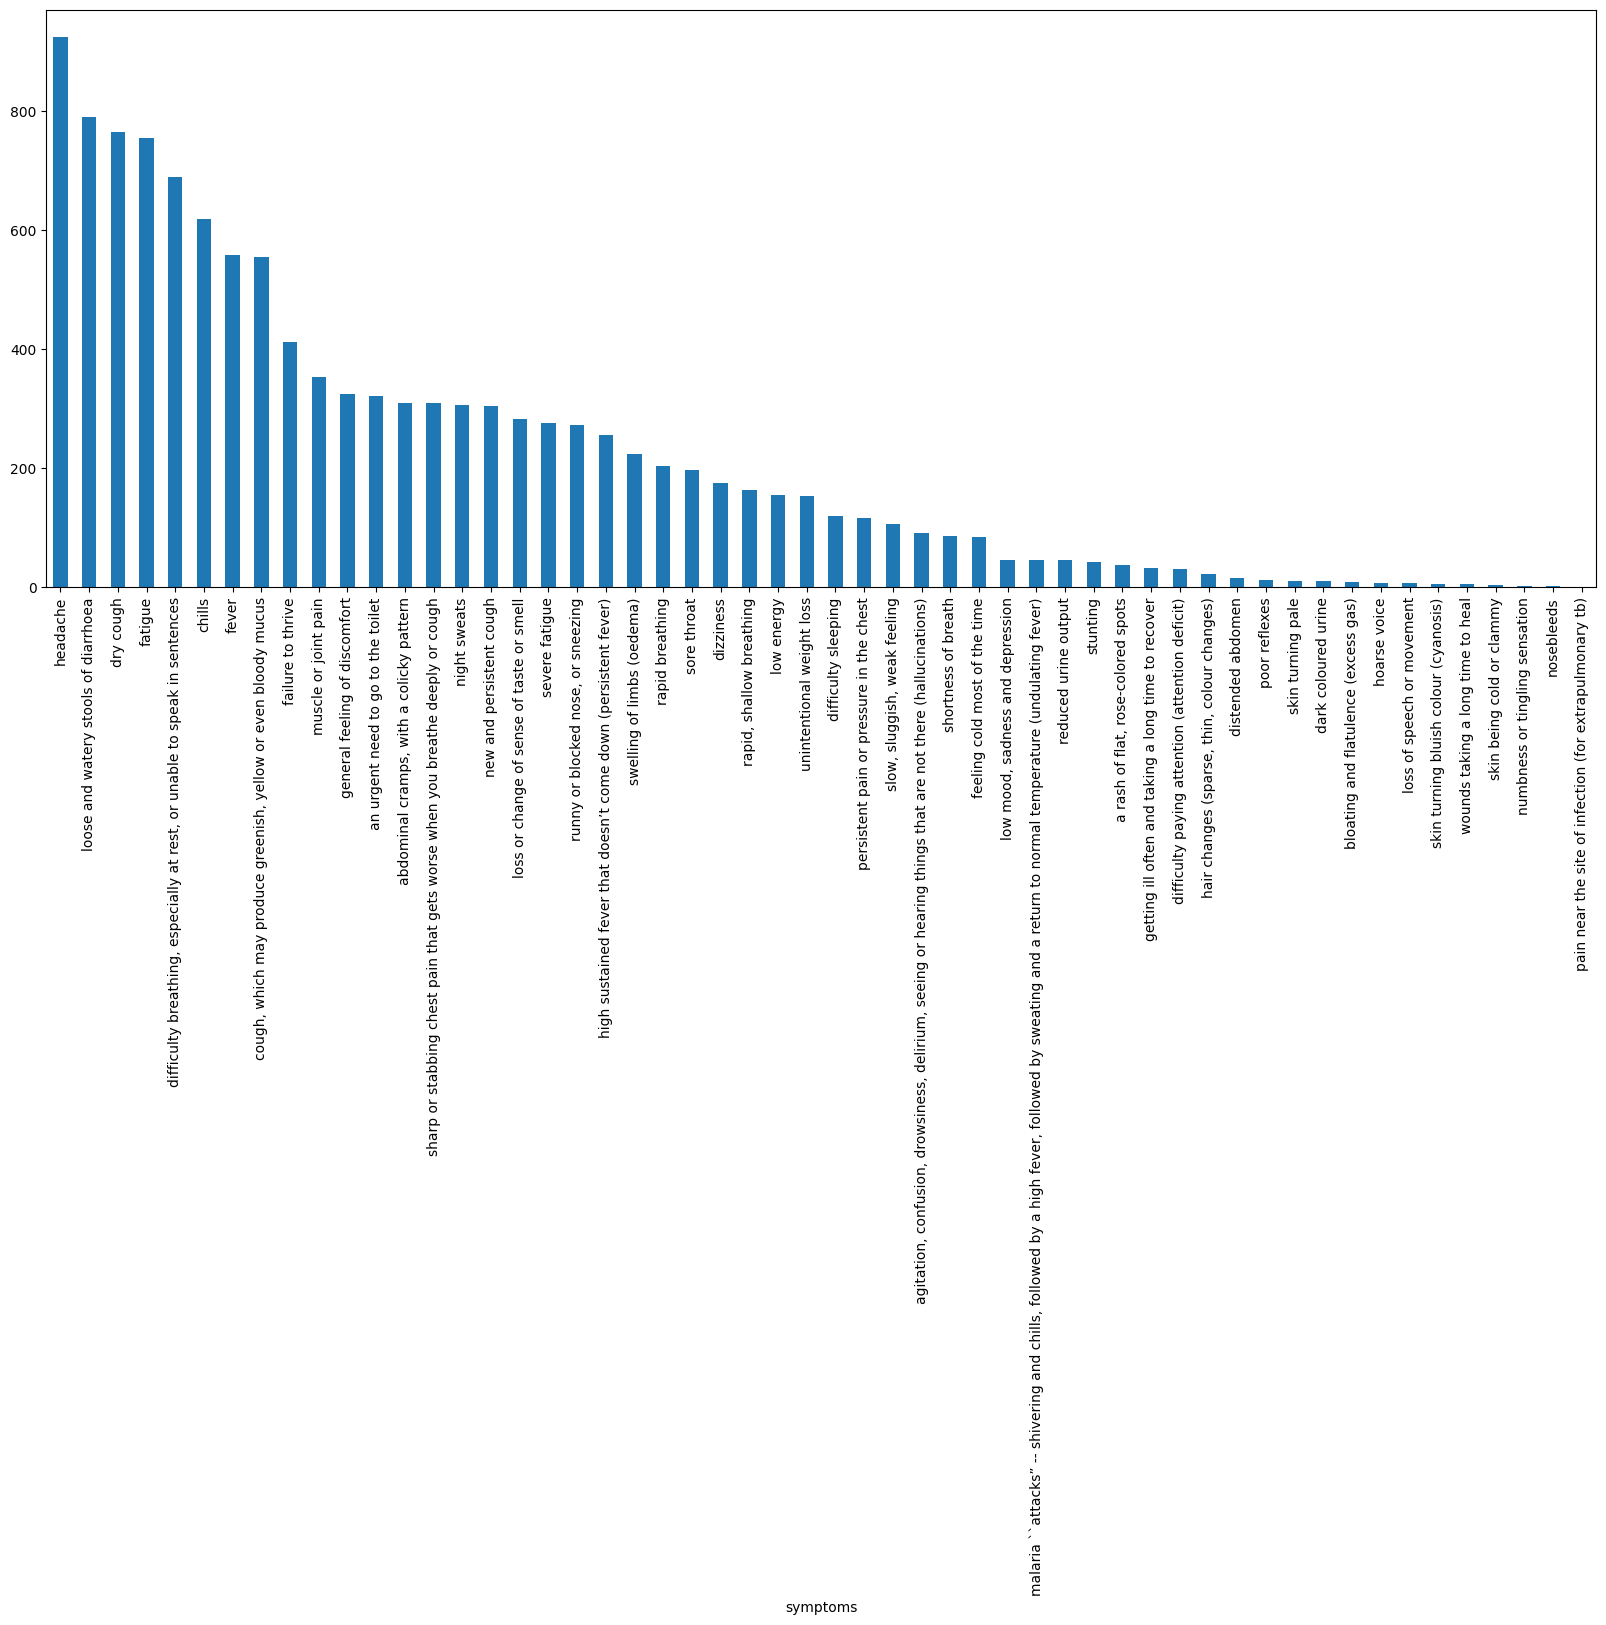

In [17]:
symptoms_by_id = df[["_uuid", "symptoms"]].drop_duplicates()
symptoms_by_id.symptoms.value_counts().plot(kind="bar", figsize=(20, 7.5))
symptoms_by_id.symptoms.value_counts().reset_index()

,system,count
0,mss,1490
1,trg,1397
2,lrs,1289
3,urs,1285
4,cns,1111
5,git,1064
6,gen,549
7,oth,366
8,sps,283
9,skn,62


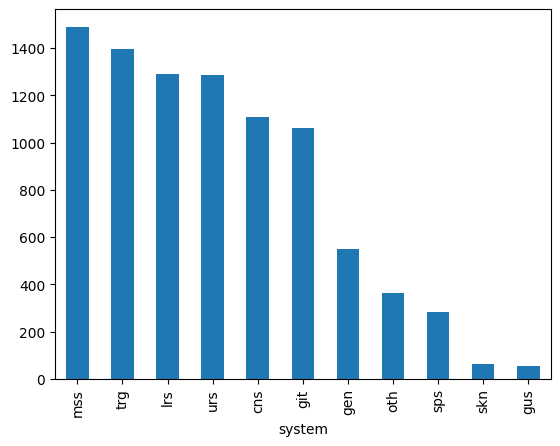

In [18]:
system_by_id = df[["_uuid", "system"]].drop_duplicates()
system_by_id.system.value_counts().plot(kind="bar")
system_by_id.system.value_counts().reset_index()

,count,mean,std,min,25%,50%,75%,max
age,3719.0,19.790054,21.099818,0.08,1.5,12.0,34.0,94.0


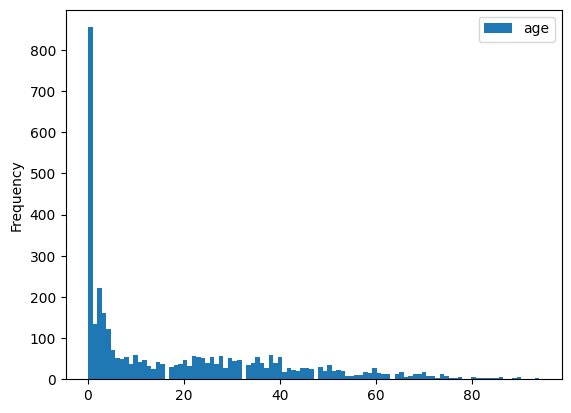

In [19]:
age_by_id = df[["_uuid", "age"]].drop_duplicates()
age_by_id.plot(kind="hist", bins=100)
age_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
height,2558.0,118.553708,45.318393,1.0,74.7,112.0,165.0,199.6


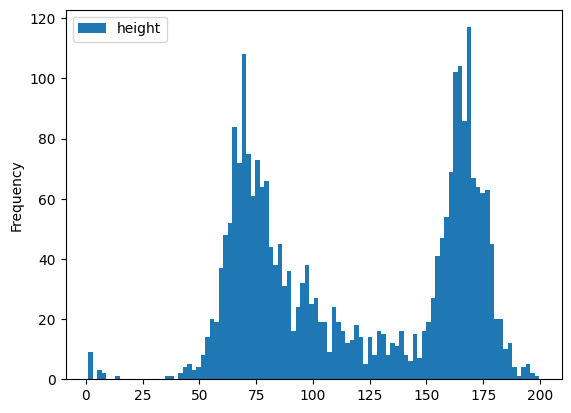

In [20]:
height_by_id = df[["_uuid", "height"]].drop_duplicates()
height_by_id.plot(kind="hist", bins=100)
height_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,2924.0,30.840975,26.919301,0.6,8.0,15.1,56.0,166.0


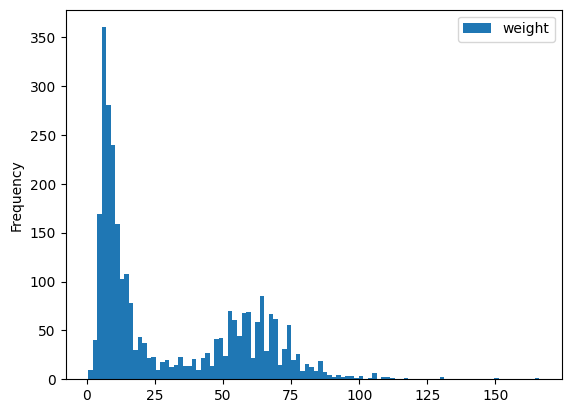

In [21]:
weight_by_id = df[["_uuid", "weight"]].drop_duplicates()
weight_by_id.plot(kind="hist", bins=100)
weight_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
bmi,2531.0,17.886952,5.884594,1.038781,13.704112,16.5,21.564545,57.670127


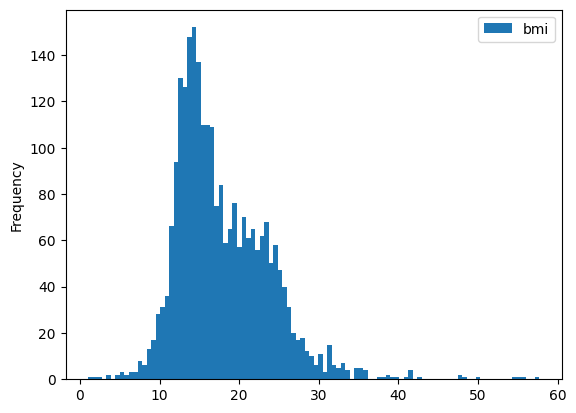

In [22]:
bmi_by_id = df[["_uuid", "bmi"]].drop_duplicates()
bmi_by_id.plot(kind="hist", bins=100)
bmi_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,2920.0,36.913661,1.03172,31.0,36.4,36.8,37.2,55.0


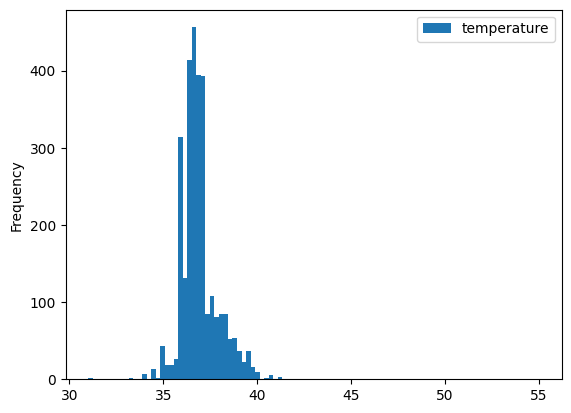

In [23]:
temperature_by_id = df[["_uuid", "temperature"]].drop_duplicates()
temperature_by_id.plot(kind="hist", bins=100)
temperature_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
spo2,1736.0,94.96371,7.478103,9.0,95.0,98.0,98.0,99.0


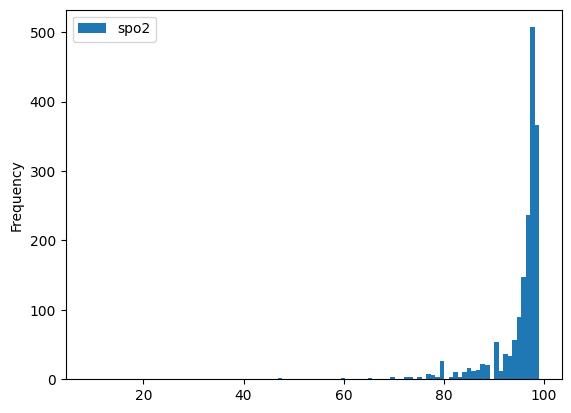

In [24]:
spo2_by_id = df[["_uuid", "spo2"]].drop_duplicates()
spo2_by_id.plot(kind="hist", bins=100)
spo2_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
bp_systolic,951.0,116.618297,18.062244,70.0,105.0,116.0,127.0,183.0
bp_diastolic,951.0,71.473186,12.032984,40.0,63.0,71.0,80.0,100.0


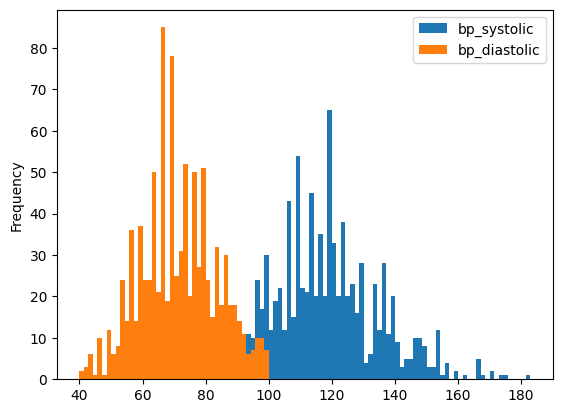

In [25]:
bp_by_id = df[["_uuid", "bp_systolic", "bp_diastolic"]].drop_duplicates()
bp_by_id.plot(kind="hist", bins=100)
bp_by_id.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,3383.0,6.803429,16.064903,1.0,2.0,3.0,7.0,365.0


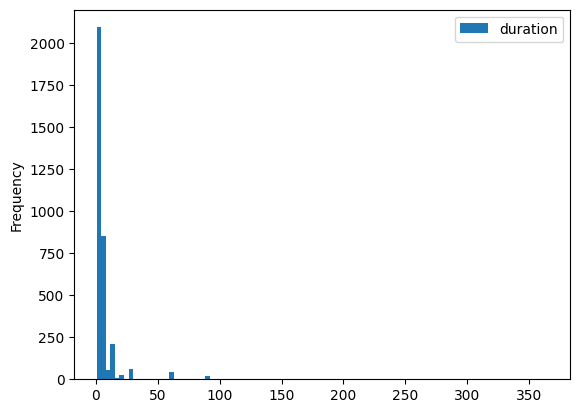

In [26]:
duration_by_id = df[["_uuid", "duration"]].drop_duplicates()
duration_by_id.plot(kind="hist", bins=100)
duration_by_id.describe().T

In [27]:
# df.dropna(subset="diagnosis", inplace=True)
# display(df.info())
# df

In [28]:
# plot tuberculosis symptoms
# plot 1. tuberculosis symptoms by duration
# plot 2. tuberculosis symptoms by age
# plot 3. tuberculosis symptoms by system
# plot 4. tuberculosis symptoms by sex
# plot 5. tuberculosis symptoms by bmi
# plot 6. tuberculosis symptoms by muac
# plot 7. tuberculosis symptoms by lab investigation
# plot 8. tuberculosis symptoms by type of tuberculosis